In [20]:
    !pip3 install imbalanced-learn
    import hopsworks
    import pandas as pd
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import os

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [21]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/226452
Connected. Call `.close()` to terminate connection gracefully.


In [22]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine_updated3", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine_updated3",
                                  version=1,
                                  description="Read from wine dataset",
                                  labels=["quality"],
                                  query=query)

In [23]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.03s) 


In [24]:
# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
model = KNeighborsRegressor(n_neighbors=4)
model.fit(X_train, y_train.values.ravel())

KNeighborsRegressor(n_neighbors=4)

In [25]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

In [26]:
print(mae, mse)

0.6746931067044382 0.7436260623229461


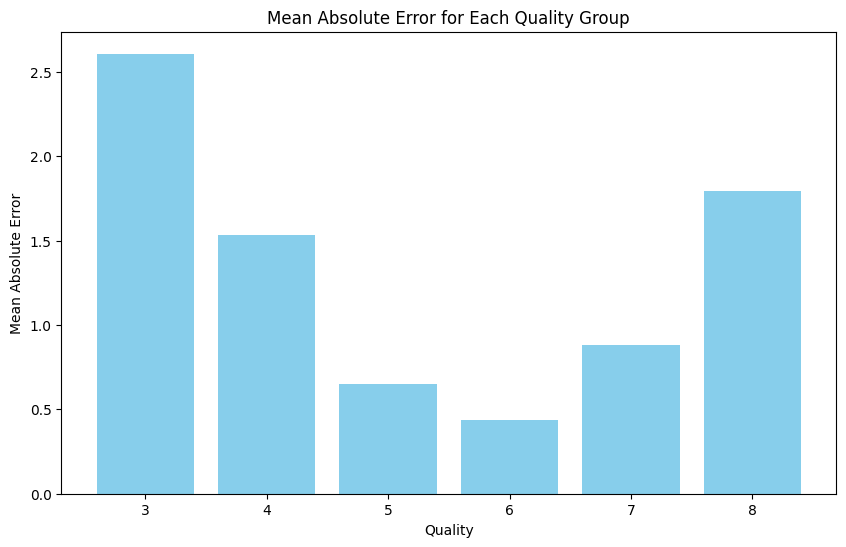

In [27]:
import matplotlib.pyplot as plt

# Convert y_pred into a panda series with the same index as y_test
y_pred_series = pd.Series(y_pred.flatten(), index=y_test.index)

# Create a DataFrame from y_test and y_pred
df_errors = pd.DataFrame({'True': y_test.squeeze(), 'Predicted': y_pred_series})

# Calculate the absolute error for each prediction
df_errors['Absolute_Error'] = abs(df_errors['True'] - df_errors['Predicted'])

# Group by the 'True' values (which represent the quality) and calculate mean error
grouped_errors = df_errors.groupby('True')['Absolute_Error'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(grouped_errors['True'], grouped_errors['Absolute_Error'], color='skyblue')
plt.xlabel('Quality')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error for Each Quality Group')
plt.show()

In [28]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
plt.savefig(model_dir + "/mae_per_quality.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"Mean Absolute Error" : mae, "Mean Squared Error" : mse},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/2396 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/436790 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/569 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/226452/models/wine_model/5


Model(name: 'wine_model', version: 5)

<Figure size 640x480 with 0 Axes>